In [6]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')

In [7]:
def epic(dtfactor=0.01, e=0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=0.93)
    sim.add(m=4.5*3.e-7, P=0.571/365.25, e=e)
    #sim.add(m=41.*3.e-7, P=13.34/365.25, e=0.01)
    sim.move_to_com()
    sim.dt = dtfactor*sim.particles[1].P
    return sim

In [8]:
def k2137b(dtfactor=0.01, e=0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=0.463)
    sim.add(m=3.e-6, P=4.3/24/365.25, e=e)
    sim.move_to_com()
    sim.dt = dtfactor*sim.particles[1].P
    return sim

In [9]:
sim = k2137b()
sim.particles[1].v

62.25323098537128

In [10]:
sim = epic()
sim.particles[1].v

53.374709345016036

In [11]:
def addGR(sim, rebxintegrator='rk4'):
    sim.integrator = "whfast"
    rebx = reboundx.Extras(sim)
    gr = rebx.load_force("gr")
    gr.params["c"] = 63197.8 # AU/yr
    intf = rebx.load_operator("integrate_force")
    intf.params['force'] = gr
    intf.params['integrator'] = reboundx.integrators[rebxintegrator]
    rebx.add_operator(intf, dt_fraction=1., timing="post")
    return rebx, gr

In [12]:
def run(dt=0.01, e=0.01, eps=None, tmax=1.e3, rebxintegrator='rk4'):
    sim = epic(dtfactor=dt, e=e)#0.080901699437494756)
    rebx, gr = addGR(sim, rebxintegrator=rebxintegrator)
    if eps:
        gr.params["c"] = np.sqrt(3*sim.particles[1].v**2/eps)#63197.8 # AU/yr
    
    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)*sim.particles[1].P
    E0 = rebx.gr_hamiltonian(gr)
    Eerr = np.zeros(Nout)
    P0 = sim.particles[1].P
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        E = rebx.gr_hamiltonian(gr)
        Eerr[i] = np.abs((E-E0)/E0)
        
    return Eerr, times/P0

In [8]:
%%time
Ndts = 10
errs = np.zeros(Ndts)
dts = np.logspace(-3, -1, Ndts)
for i, dt in enumerate(dts):
    err, times = run(dt=dt)
    errs[i] = np.max(err)

CPU times: user 3.74 s, sys: 0 ns, total: 3.74 s
Wall time: 3.74 s


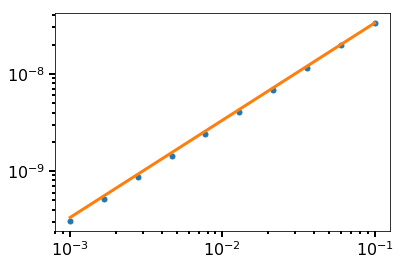

In [118]:
fig, ax = plt.subplots()
ax.loglog(dts, errs, '.')
ax.loglog(dts, errs[-1]*(dts/dts[-1]))

In [119]:
%%time
Nes = 10
errs = np.zeros(Nes)
es = np.logspace(-3, -1, Nes)
for i, e in enumerate(es):
    err, times = run(e=e)
    errs[i] = np.max(err)

CPU times: user 1.71 s, sys: 4.01 ms, total: 1.71 s
Wall time: 1.71 s


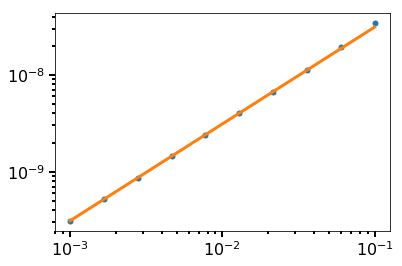

In [120]:
fig, ax = plt.subplots()
ax.loglog(es, errs, '.')
ax.loglog(es, errs[0]*es/es[0])

In [121]:
%%time
Neps = 10
errs = np.zeros(Neps)
epss = np.logspace(-8, -2, Neps)
for i, eps in enumerate(epss):
    err, times = run(eps=eps)
    errs[i] = np.max(err)

CPU times: user 1.73 s, sys: 3.99 ms, total: 1.73 s
Wall time: 1.73 s


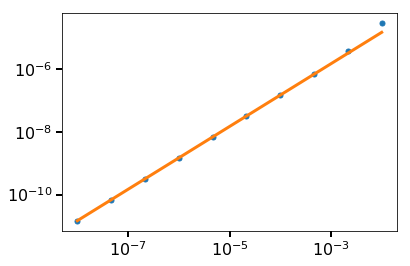

In [122]:
fig, ax = plt.subplots()
ax.loglog(epss, errs, '.')
ax.loglog(epss, errs[0]*epss/epss[0])

In [123]:
%%time
dt=0.01
e=1.e-2
eps=1.e-5
tmax=1.e3
err, times = run(dt=dt, e=e, eps=eps, tmax=tmax)

CPU times: user 204 ms, sys: 20 µs, total: 204 ms
Wall time: 202 ms


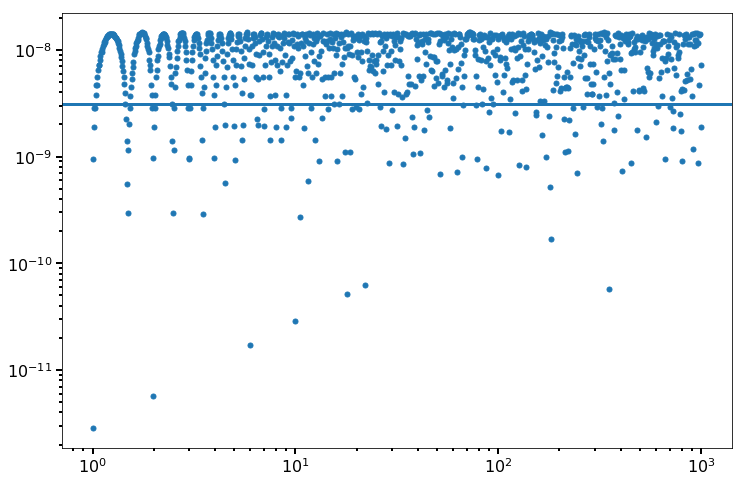

In [125]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, err, '.')
ax.axhline((2*np.pi)/2*eps*dt*e)#0.080901699437494756*0.01)
ax.set_xscale('log')
ax.set_yscale('log')

In [132]:
%%time
dt=0.01
e=1.e-2
eps=1.e-5
tmax=1.e5
err, times = run(dt=dt, e=e, eps=eps, tmax=tmax, rebxintegrator='euler')

CPU times: user 7.25 s, sys: 1 µs, total: 7.25 s
Wall time: 7.25 s


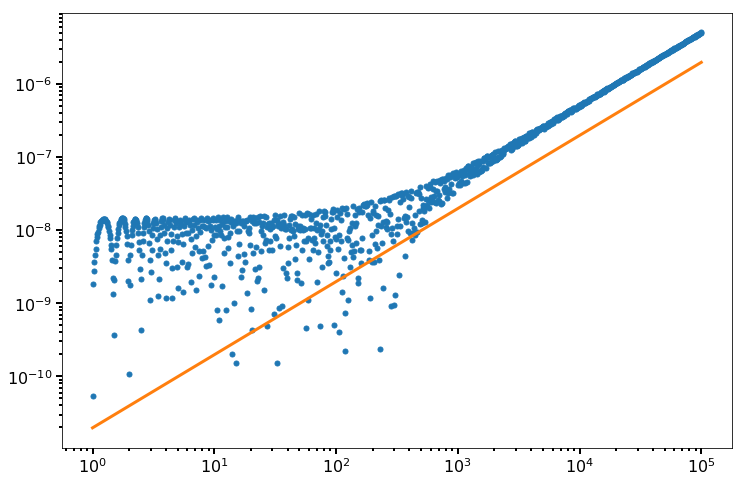

In [133]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, err, '.')
ax.plot(times, (2*np.pi)**2/2*eps**2*dt*times)
ax.set_xscale('log')
ax.set_yscale('log')

In [13]:
dtfactor = 0.080901699437494756
rebxintegrator = 'rk4'
tmax = 1.e4
order = 1
epsfac = 1
filename = 'data/epsfac{0}rebx{1}dt{2:.3e}order{3}'.format(epsfac, rebxintegrator, dtfactor, order)

sim = k2137b(dtfactor=dtfactor, e=0.01)
rebx, gr = addGR(sim, rebxintegrator=rebxintegrator)
gr.params["c"] /= np.sqrt(epsfac)

sim.simulationarchive_snapshot(filename+".sa")
rebx.save(filename+'.rebx')

Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)*sim.particles[1].P
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    sim.simulationarchive_snapshot(filename+".sa")        

In [16]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')

dtfactor = 0.080901699437494756
rebxintegrator = 'rk4'
tmax = 1.e4
order = 1
epsfac = 1
filename = 'data/epsfac{0}rebx{1}dt{2:.3e}order{3}'.format(epsfac, rebxintegrator, dtfactor, order)

sa = reboundx.SimulationArchive(filename+'.sa', rebxfilename = filename+".rebx")
sim, rebx = sa[0]
gr = rebx.get_force("gr")
E0 = rebx.gr_hamiltonian(gr)
Eerr = np.zeros(len(sa))
times = np.zeros(len(sa))
for i, (sim, rebx) in enumerate(sa):
    E = rebx.gr_hamiltonian(rebx.get_force("gr"))
    Eerr[i] = np.abs((E-E0)/E0)
    times[i] = sim.t

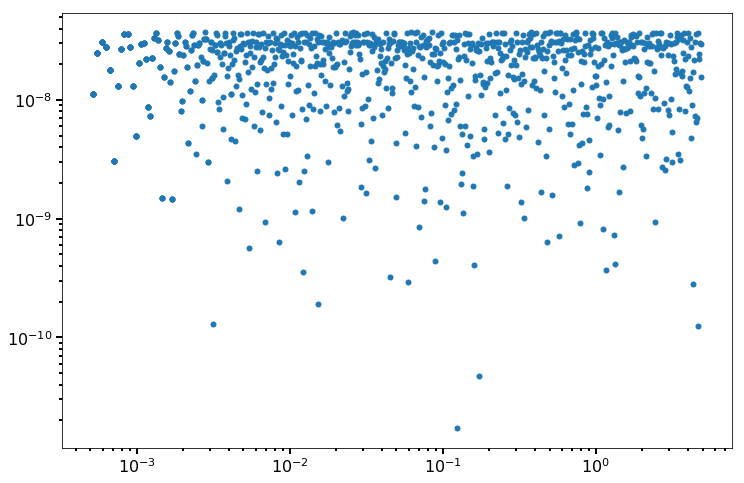

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Eerr, '.')
ax.set_xscale('log')
ax.set_yscale('log')

In [12]:
force.params['force']